In [1]:
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdMolTransforms as rmt
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import datamol as dm

from src.data.datasets import *
from rdkit.Chem import rdMolTransforms as rmt
from rdkit.Chem import rdMolDescriptors

In [2]:
# load datasets
crossdocked_generated = DockedMolsDataset("crossdocked_test", docked=False)
crossdocked_docked = DockedMolsDataset("crossdocked_test", docked=True)

diffsbdd_generated = DiffSBDDSamples(docked=False)
diffsbdd_docked = DiffSBDDSamples(docked=True)

targetdiff_generated = DockedMolsDataset("targetdiff", docked=False)
targetdiff_docked = DockedMolsDataset("targetdiff", docked=True)

p2m_generated = DockedMolsDataset("pocket2mol", docked=False)
p2m_docked = DockedMolsDataset("pocket2mol", docked=True)

sbdd_generated = DockedMolsDataset("ar", docked=False)
sbdd_docked = DockedMolsDataset("ar", docked=True)

cvae_generated = DockedMolsDataset("cvae", docked=False)
cvae_docked = DockedMolsDataset("cvae", docked=True)

In [19]:
crossdocked = crossdocked_docked.data
targetdiff = targetdiff_generated.data
p2m = p2m_generated.data
sbdd = sbdd_generated.data
cvae = cvae_generated.data

In [4]:
targetdiff[0][0]["vina"]["dock"][0]["affinity"]

-9.047

In [29]:
data = targetdiff


def calulate_ligand_efficiency(data):
    ligand_efficiency = []

    for target in data:
        if type(target) != list:
            target = [target]

        for sample in target:
            mol = sample["mol"]
            affinity = sample["vina"]["dock"][0]["affinity"]

            if affinity == None:
                continue

            mw = rdMolDescriptors.CalcExactMolWt(mol)
            # ligand efficiency
            le = affinity / mw
            ligand_efficiency.append({"le": le, "affinity": affinity, "mw": mw})

    return ligand_efficiency


crossdocked_le = calulate_ligand_efficiency(crossdocked)
targetdiff_le = calulate_ligand_efficiency(targetdiff)
p2m_le = calulate_ligand_efficiency(p2m)
sbdd_le = calulate_ligand_efficiency(sbdd)
cvae_le = calulate_ligand_efficiency(cvae)

# into dataframe
crossdocked_df = pd.DataFrame(
    crossdocked_le, columns=["ligand_efficiency", "affinity", "mw"]
)
crossdocked_df["dataset"] = "crossdocked"

targetdiff_df = pd.DataFrame(
    targetdiff_le, columns=["ligand_efficiency", "affinity", "mw"]
)
targetdiff_df["dataset"] = "targetdiff"

p2m_df = pd.DataFrame(p2m_le, columns=["ligand_efficiency", "affinity", "mw"])
p2m_df["dataset"] = "pocket2mol"

sbdd_df = pd.DataFrame(sbdd_le, columns=["ligand_efficiency", "affinity", "mw"])
sbdd_df["dataset"] = "sbdd"

cvae_df = pd.DataFrame(cvae_le, columns=["ligand_efficiency", "affinity", "mw"])
cvae_df["dataset"] = "cvae"

# combine
df = pd.concat([targetdiff_df, p2m_df, sbdd_df, cvae_df, crossdocked_df])

# remove outliers
# df = df[df['ligand_efficiency'] < 0.0]

(-12.0, -2.0)

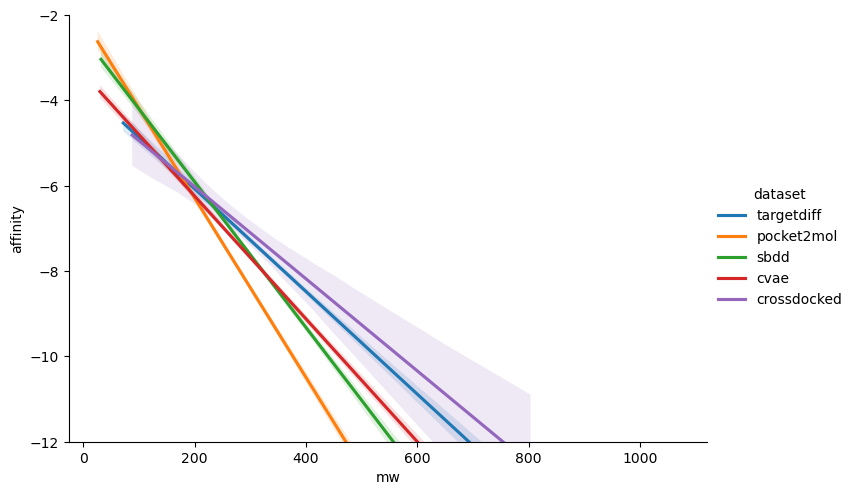

In [33]:
# do linear regression for all methods
sns.lmplot(
    x="mw",
    y="affinity",
    data=df,
    hue="dataset",
    height=5,
    aspect=1.5,
    scatter_kws={"alpha": 0.3},
    scatter=False,
)
plt.ylim(-12, -2)

(-15.0, -5.0)

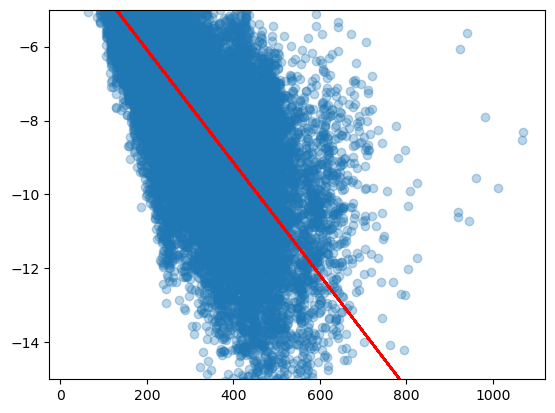

In [18]:
# do linear regression for all methods with numpy
import numpy as np
from sklearn.linear_model import LinearRegression

# get data
x = df["mw"].values.reshape(-1, 1)
y = df["affinity"].values.reshape(-1, 1)

# fit model
model = LinearRegression()
model.fit(x, y)

# get predictions
y_pred = model.predict(x)

# plot
plt.scatter(x, y, alpha=0.3)
plt.plot(x, y_pred, color="red")
plt.ylim(-15, -5)